First, let's see what it takes to detect bursts with specparam

In [6]:
import json
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn

import specparam

from neurodsp.spectral import compute_spectrum
from neurodsp.burst import detect_bursts_dual_threshold, compute_burst_stats
from neurodsp.plts.time_series import plot_time_series, plot_bursts

import itertools

In [ ]:

from math import nan
from numpy import ndarray


num_real_sigs = 49
fs = 1000


def reverse_order(j, order):
    for i in range(len(order)):
        if j == order[i]:
            return i


# Load data
with open("./voyteklabstudy-default-rtdb-export.json") as f:
    results = json.load(f)


def plot_signal(y):
    x = np.linspace(0, len(y), len(y))

    plt.plot(x, y)

# unfinished

# runtime analysis of (num_bursting_intervals + get_bursting_intervals):
# 
def num_bursting_intervals(is_burst) -> int:
    bursting_interval_count = 0
    if is_burst[0]:
        bursting_interval_count=1
    siglen = len(is_burst)
    for i in range(0, siglen-1):
        val_at_i = is_burst[i]
        val_at_i_plus_1 = is_burst[i+1]
        if (not val_at_i) and val_at_i_plus_1:
            bursting_interval_count += 1

    return bursting_interval_count

# accommodates multiple intervals right now. can be optimized (a tiny bit) by restricting one interval
def get_bursting_intervals(is_burst, num_intervals):
    bursting_intervals = [[0,0]]*num_intervals
    burst_interval_index = 0
    siglen = len(is_burst)

    if is_burst[0]:
        bursting_intervals[0][0]=0
    for i in range(0, siglen-1):
        val_at_i = is_burst[i]
        val_at_i_plus_1 = is_burst[i+1]
        if val_at_i and (not val_at_i_plus_1):
            bursting_intervals[burst_interval_index][1]=i
            burst_interval_index += 1
        elif (not val_at_i) and val_at_i:
            bursting_intervals[burst_interval_index][0]=i
    return bursting_intervals


# Returns input for ROC_AUC algorithm (probabilistic attempt)
# to use:
# give X=ground_truth burst array of booleans
# give Y=labeler-predicted burst array of booleans
# 
# Returns [(1 - P(x_i=False | y_i=False), P(x_i=True | y_i=True)]) given boolean lists X,Y 
# OR the algorithm returns an integral Error code.
#   Code 1: len(X)!=len(Y)
#   Code 2: X[i] or Y[i] is not boolean
def probability_correct_selection(X,Y):
    num_true = 0
    num_false = 0
    selected_true=0
    selected_false = 0

    if len(X) != len(Y):
        return 1
    for i in range(len(X)):
        xi = X[i]
        yi = Y[i]
        if type(xi) != bool or yi != bool:
            return 2
        if xi:
            num_true+=1
            if yi:
                selected_true+=1
        else:
            num_false+=1
            if not yi:
                selected_false+=1
    
    P_0 = float(selected_false)/float(num_false)
    P_1 = float(selected_true)/float(num_true)
    
    return [1-P_0, P_1]
        



    

In [3]:

# ground truth has shape (num_participants,2)
# it shows the correct bursting classification
ground_truth = np.array(results["ground_truth"])

# List of names of human collaborators who labeled data
# length of which gives us number of labelings
who = list(results["selections"].keys())
print(type(who))
name = who[0]

result_element = results["selections"][who[0]]

# Performance:
error = np.zeros((len(who), 50, 2))

print("name is %s" % name)
# the i'th element of `order` is the index in signals, corresponding to the i'th signal the labeler saw.
order = np.array(results["selections"][name]['indices'])


<class 'list'>
name is Andrew Bender@1714089263343



FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

nan
(0, 901)

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

17.01685099278513
(0, 0)

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a l

/Users/kenton/HOME/coding/python/publish_the_paper/path/to/venv/lib/python3.12/site-packages/neurodsp/plts/utils.py:26: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  _, ax = plt.subplots(figsize=figsize)


(0, 0)

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

nan
(0, 623)

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recommend a lower bound of approximately 2x the frequency resolution.

13.460054460644818
(0, 0)

FITTING WARNING: Skipping frequency == 0, as this causes a problem with fitting.

	Lower bounds below frequency-resolution have no effect (effective lower bound is the frequency resolution).
	Too low a limit may lead to overfitting noise as small bandwidth peaks.
	We recom

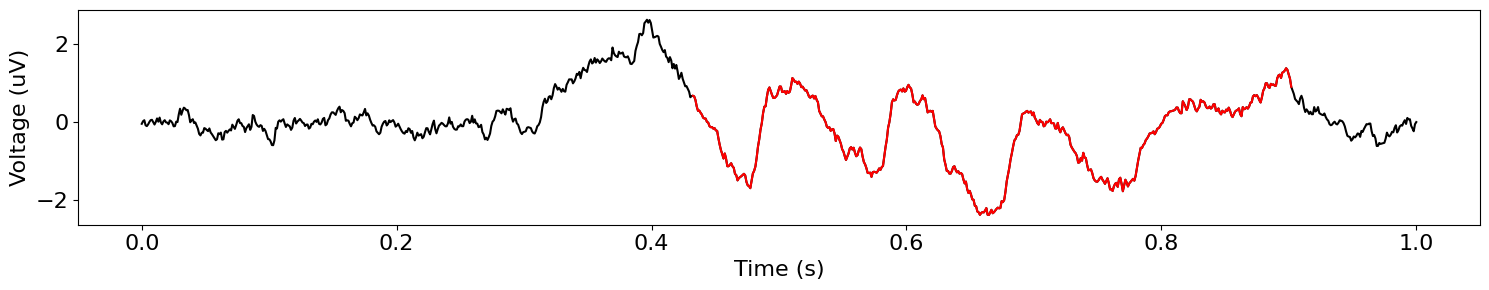

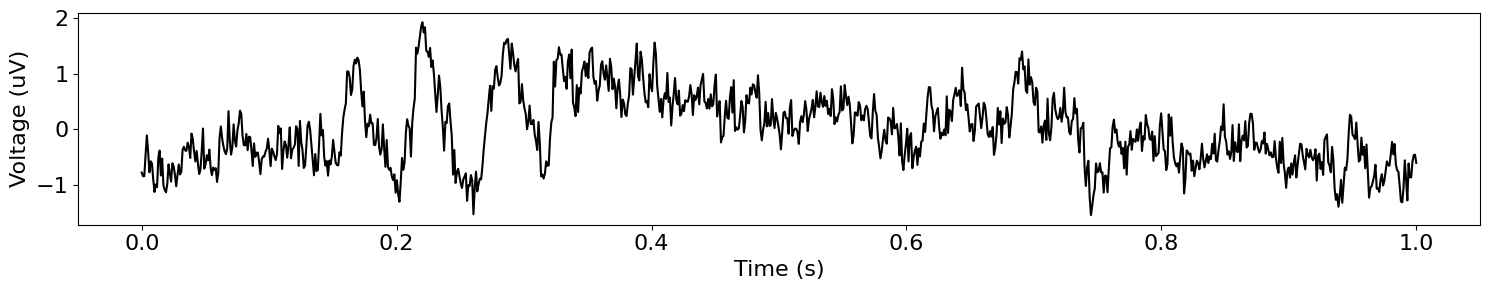

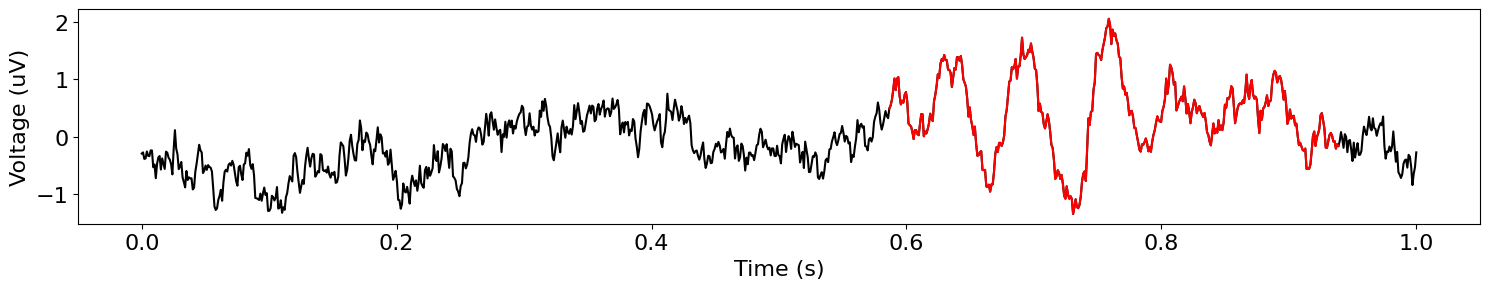

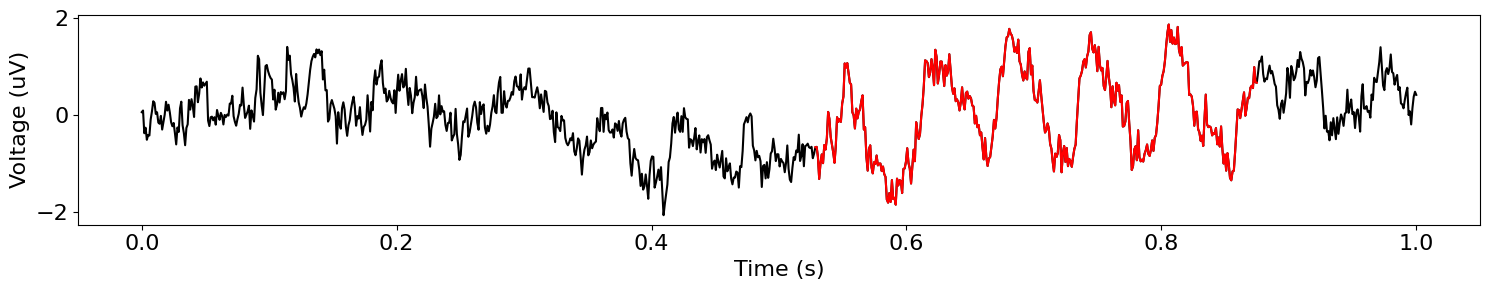

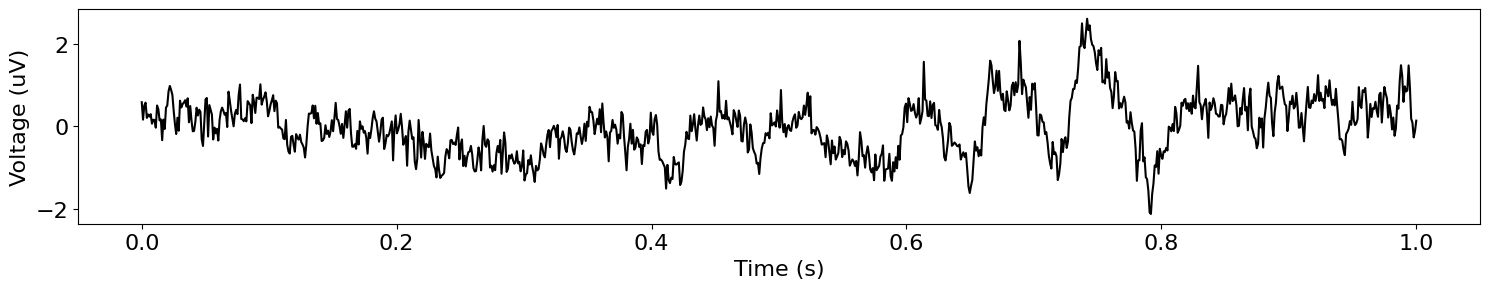

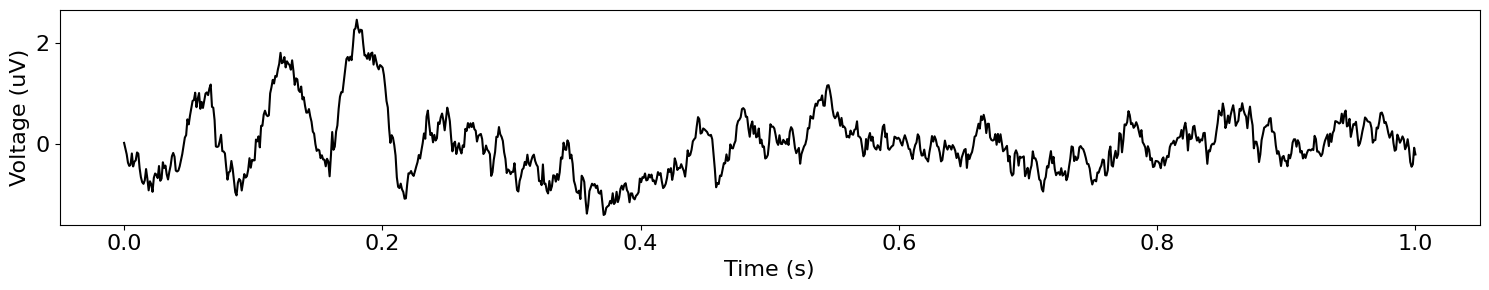

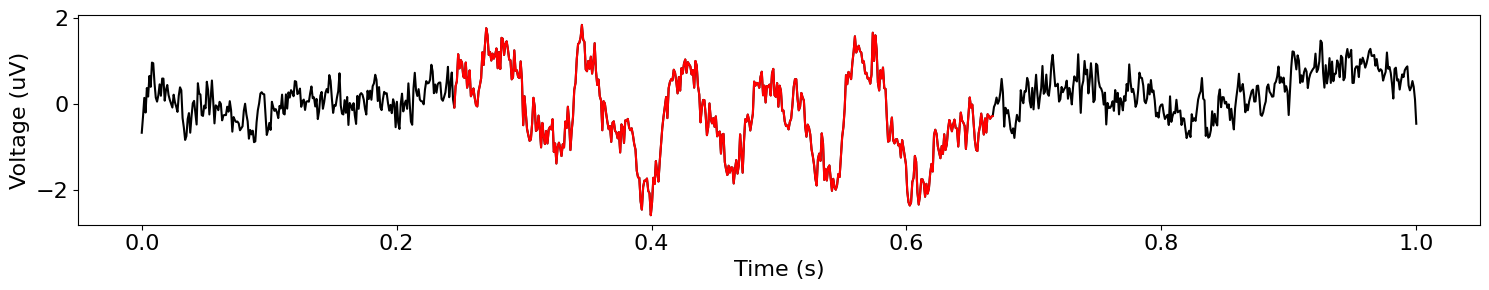

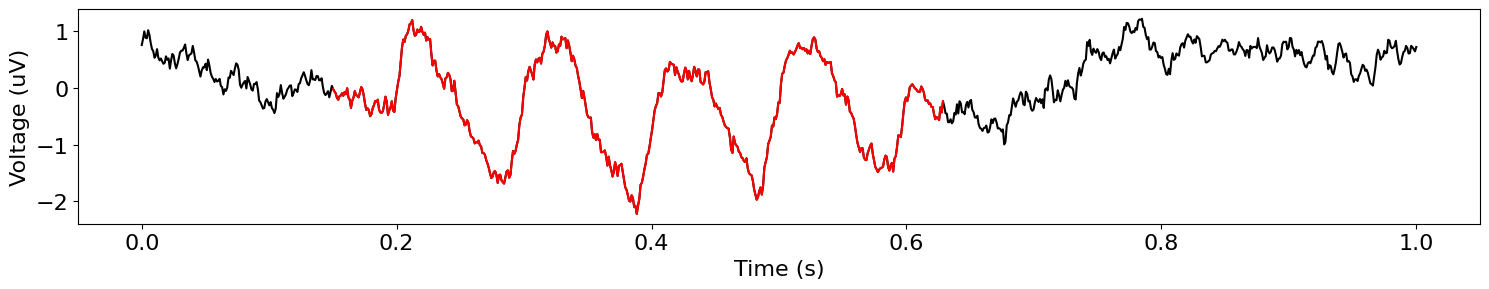

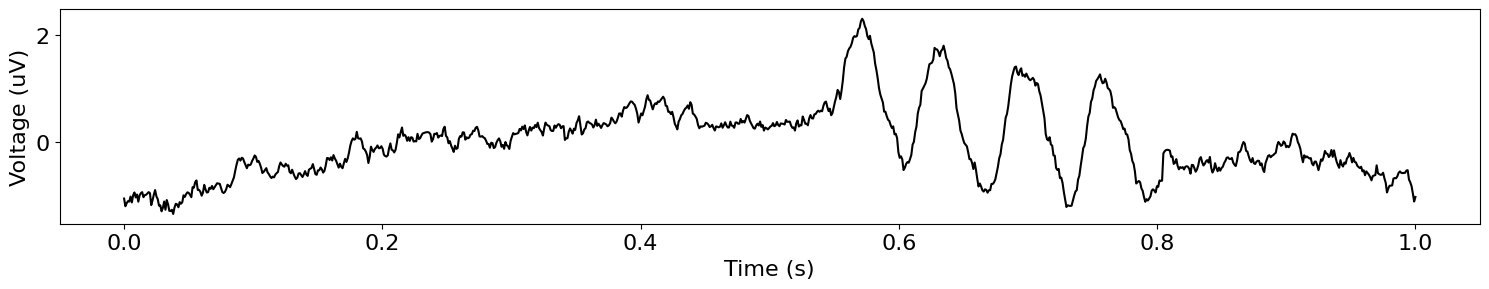

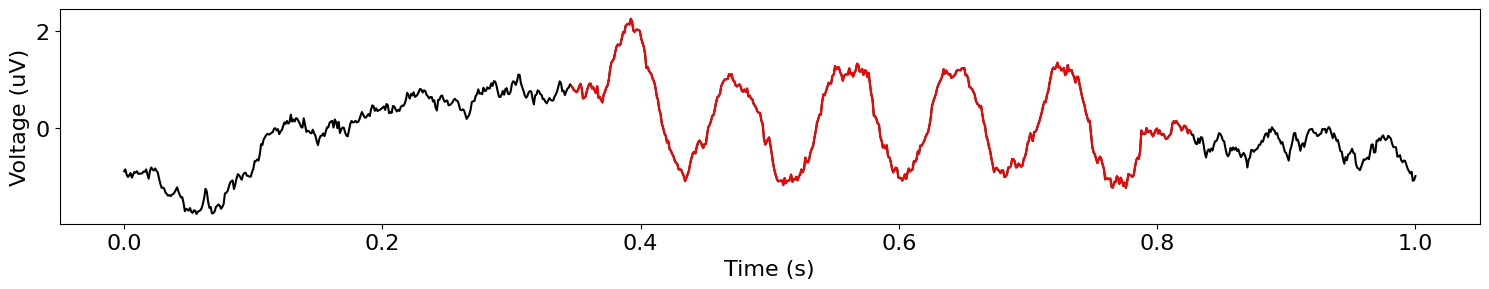

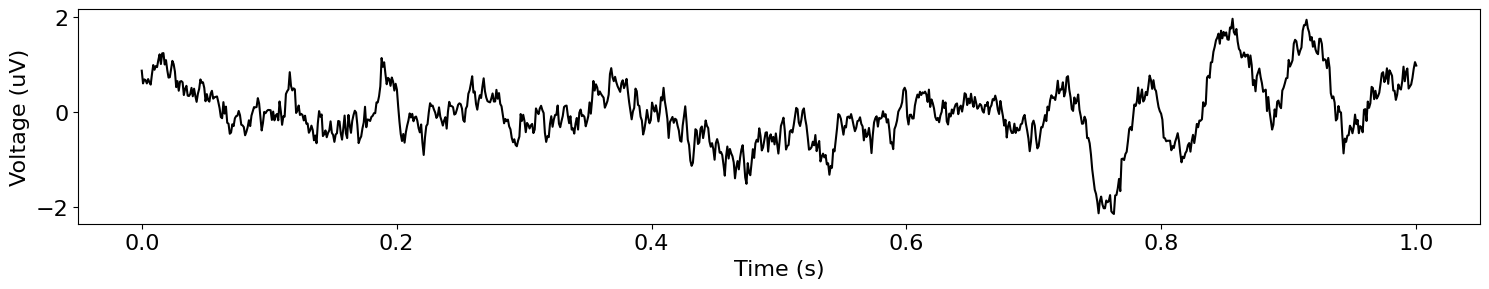

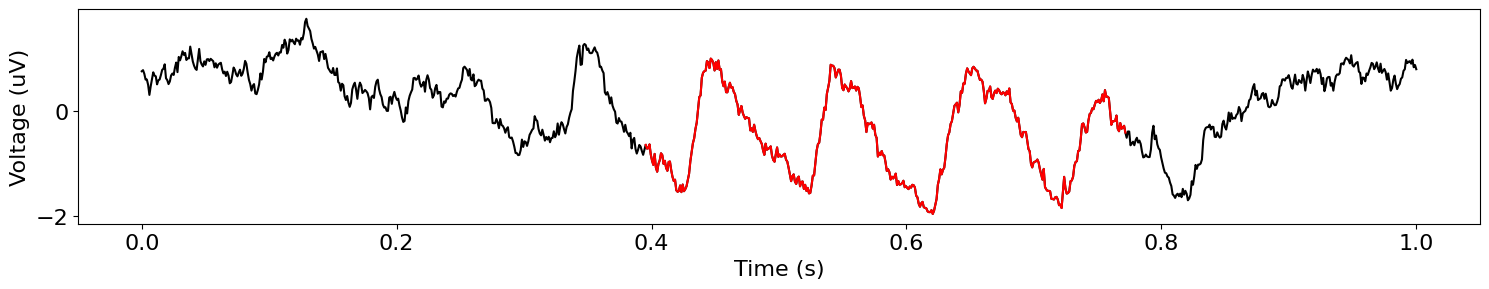

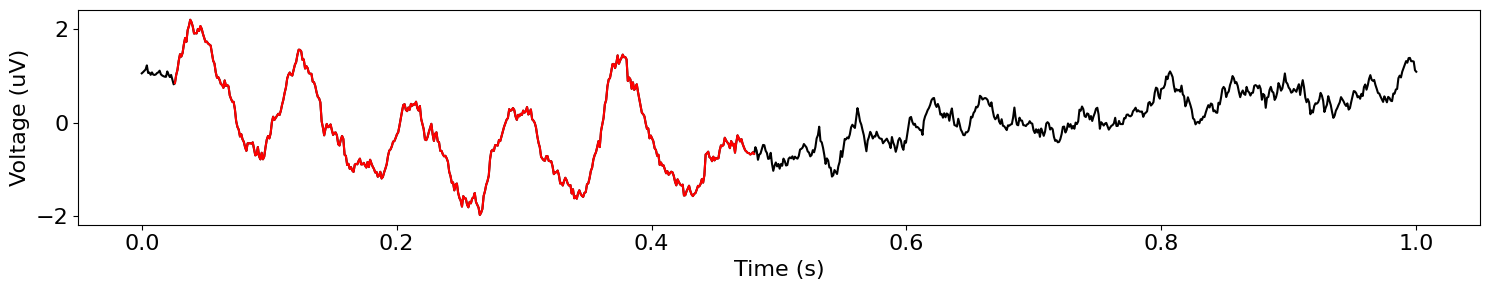

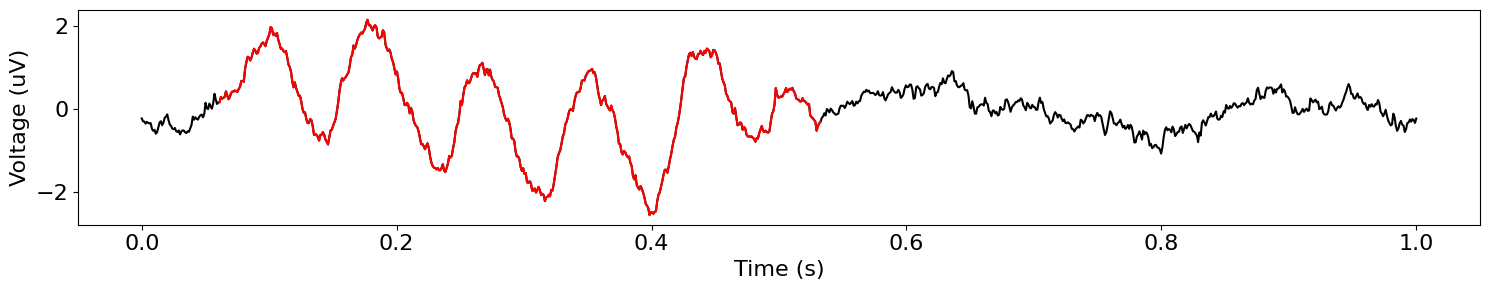

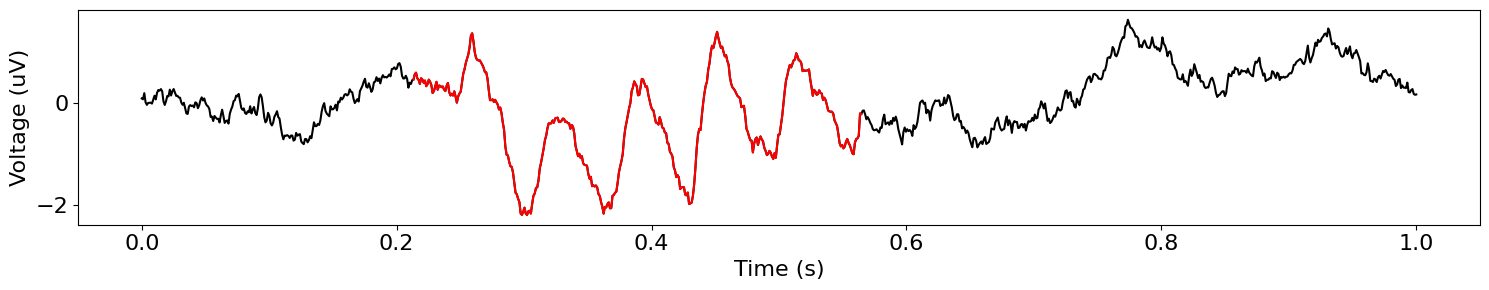

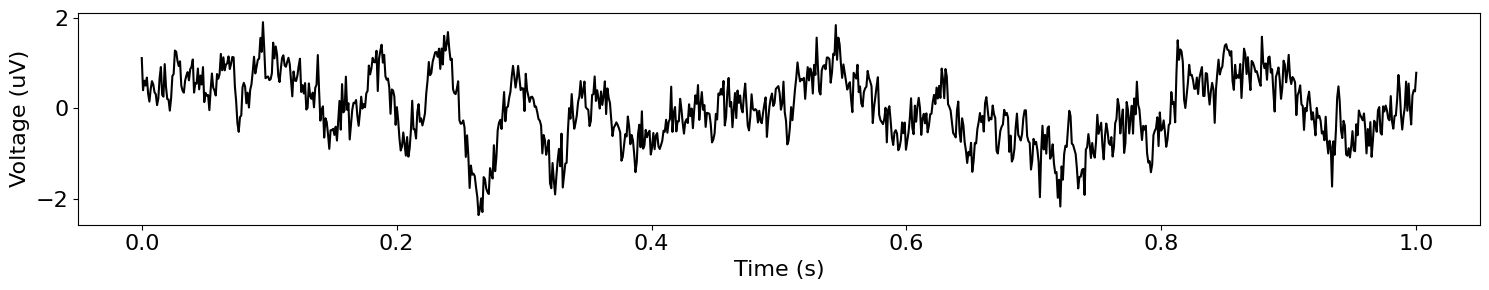

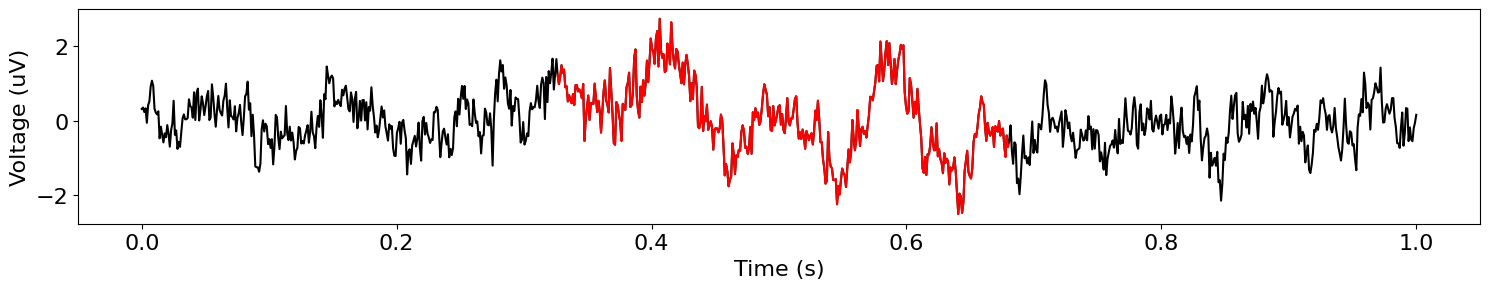

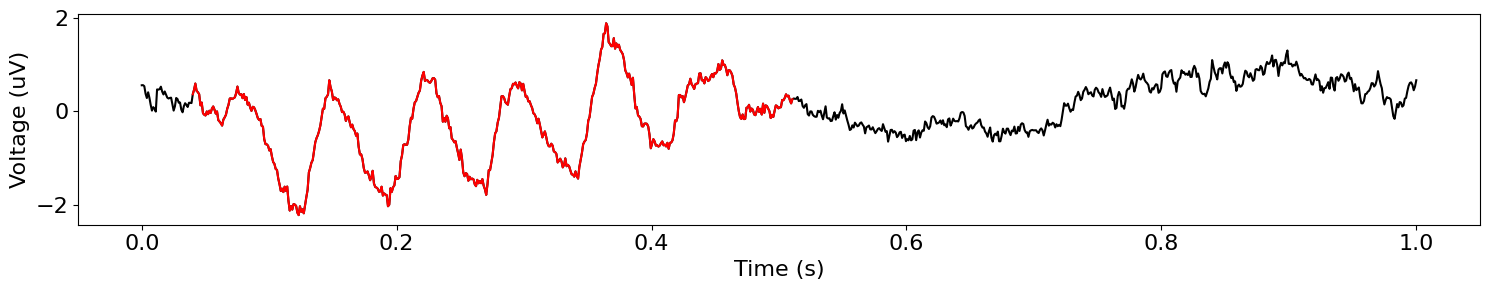

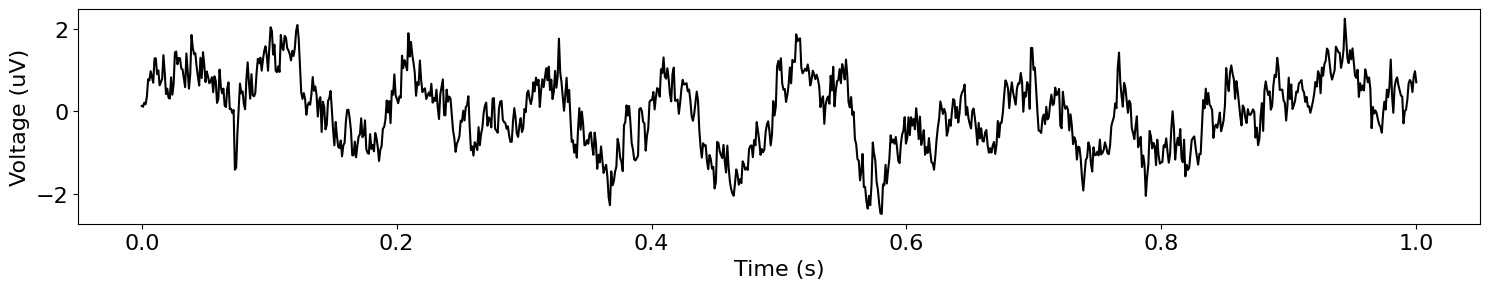

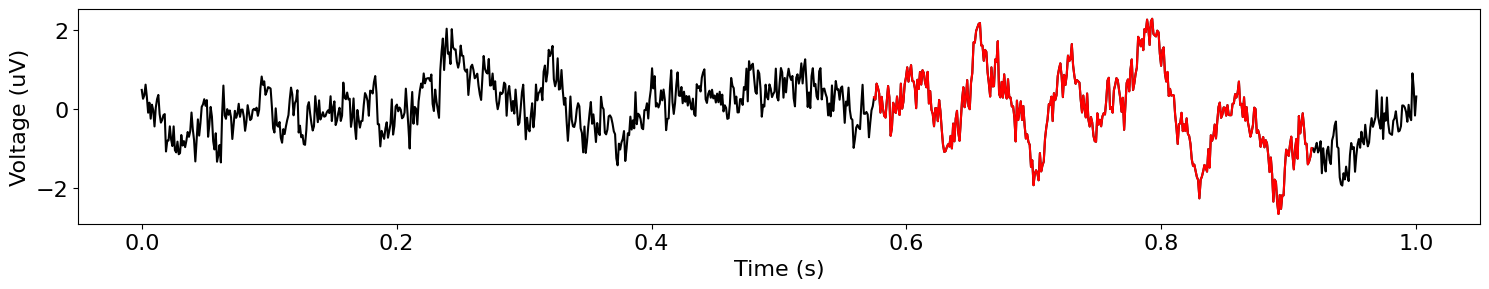

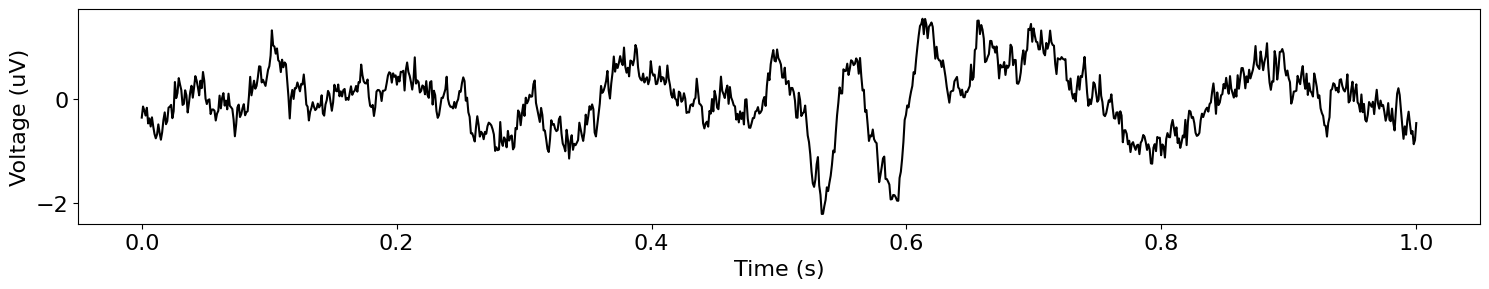

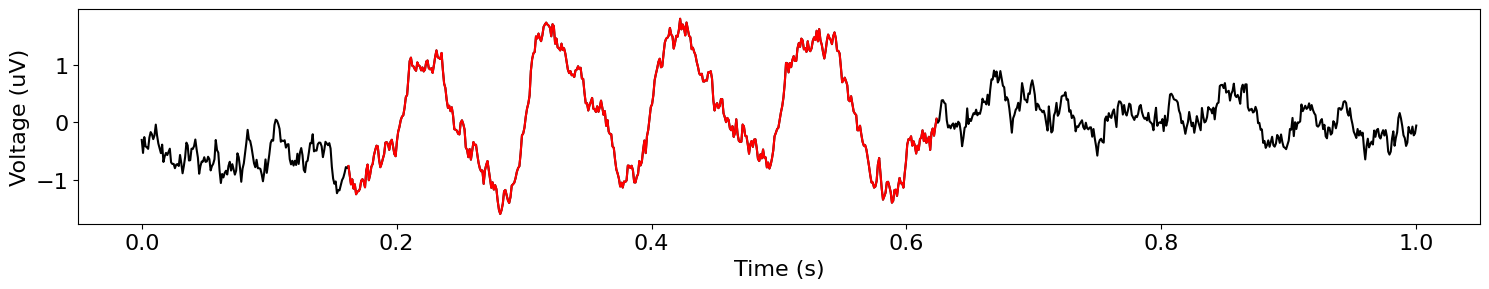

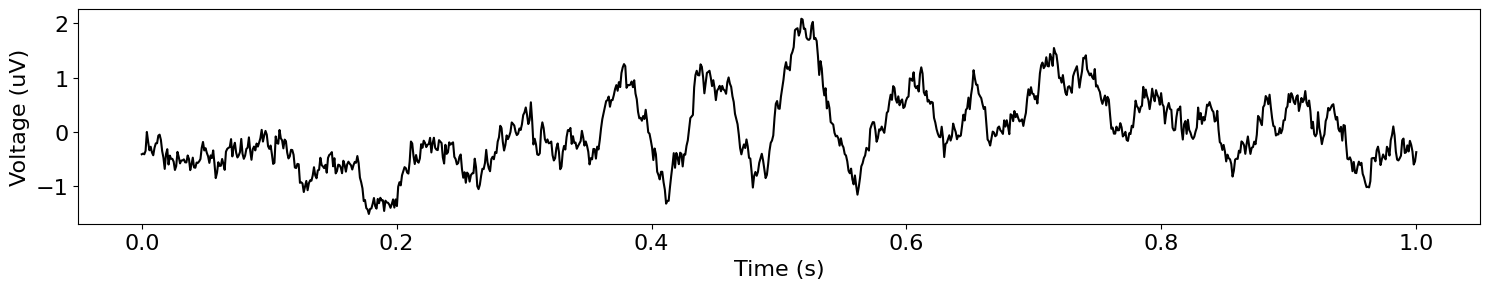

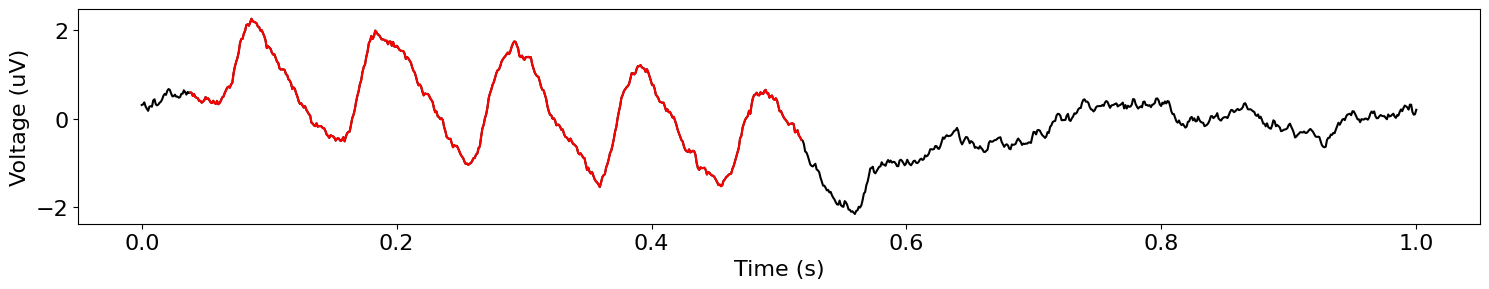

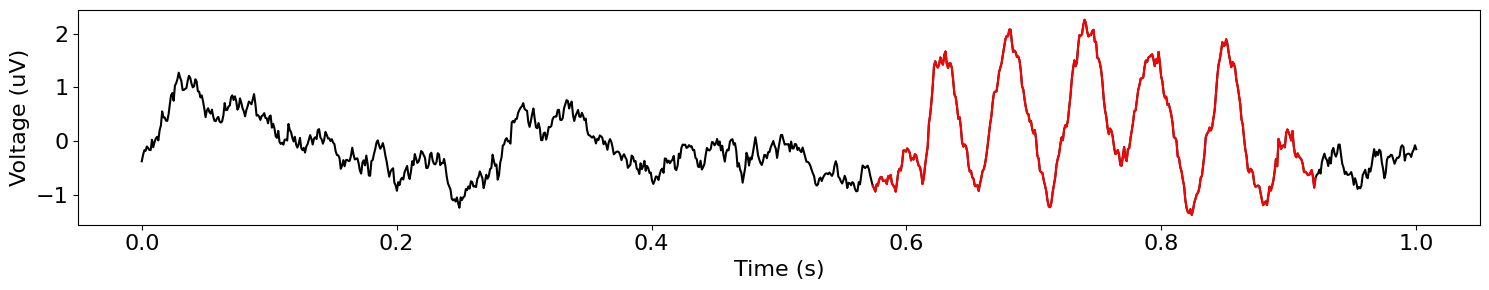

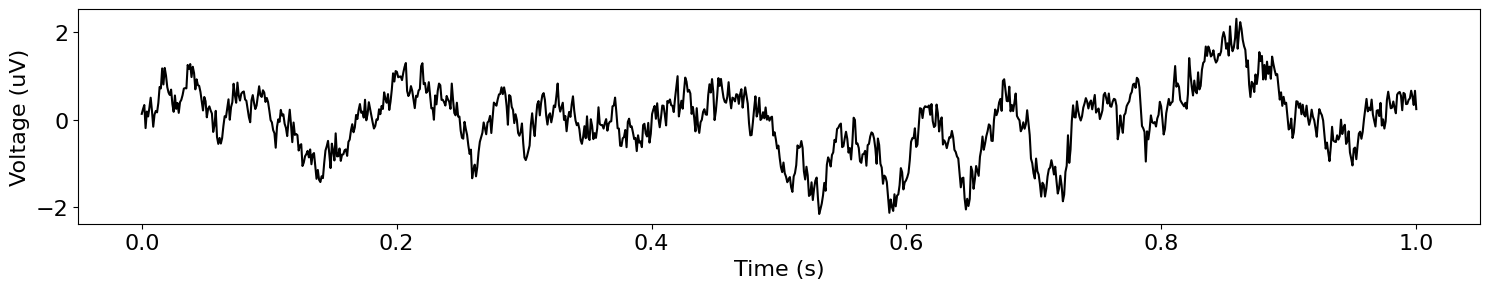

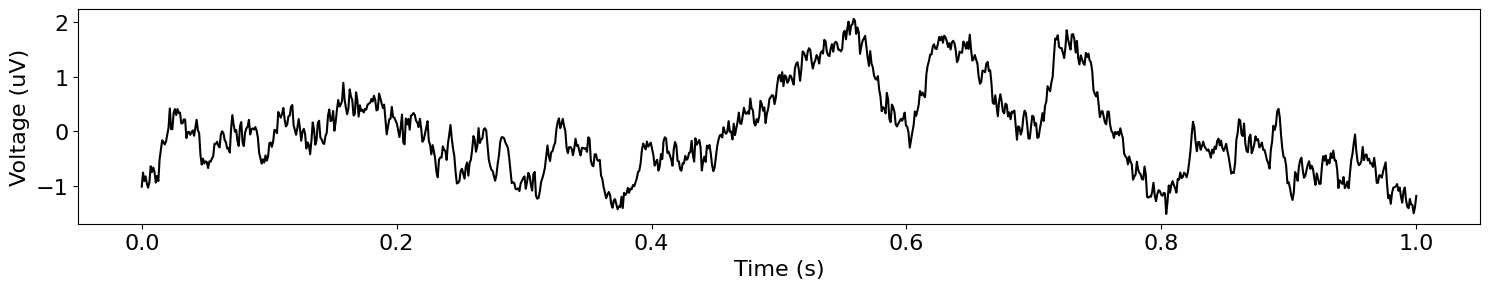

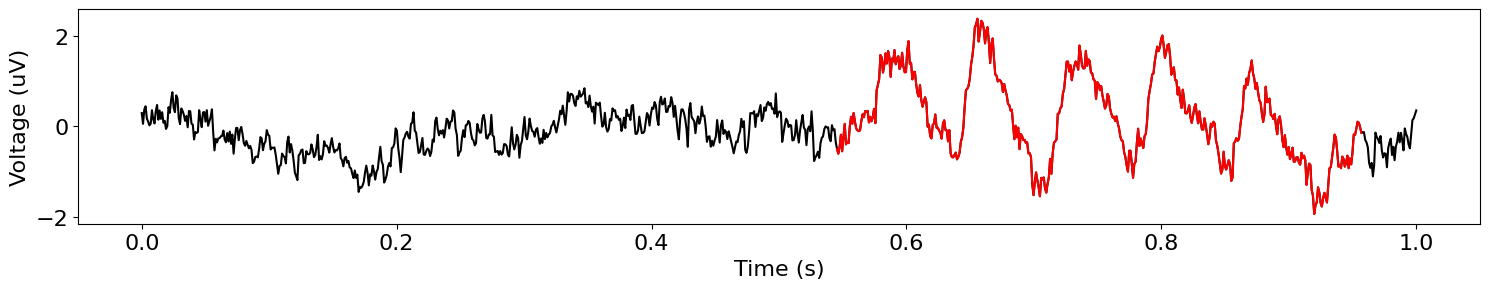

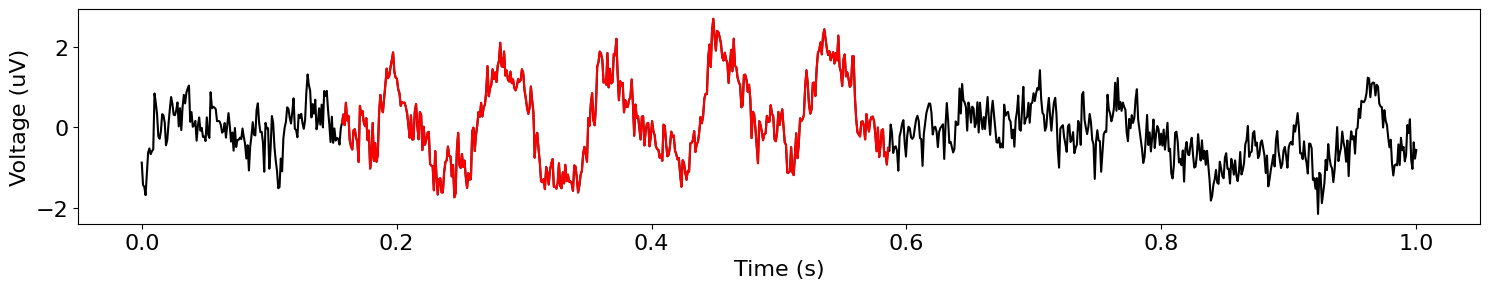

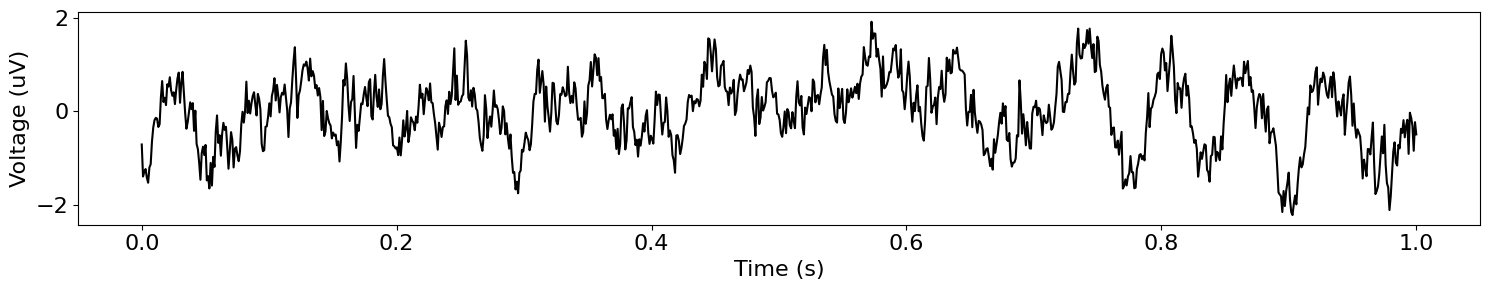

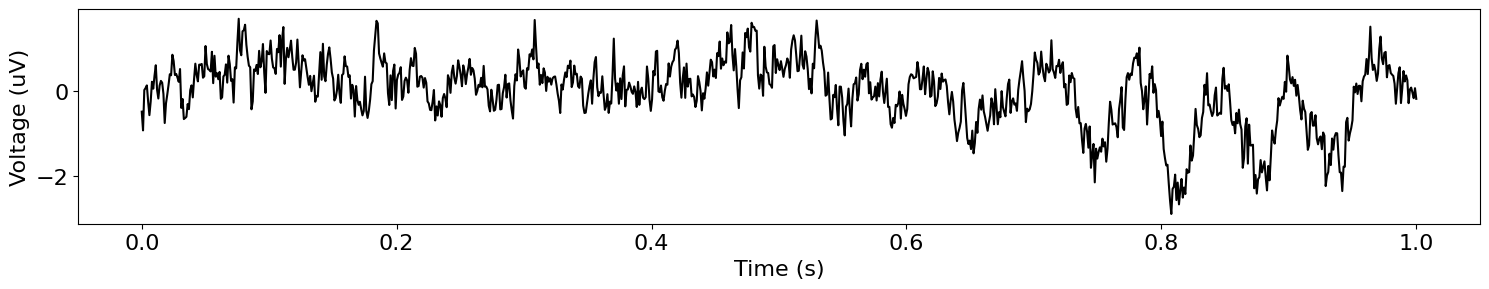

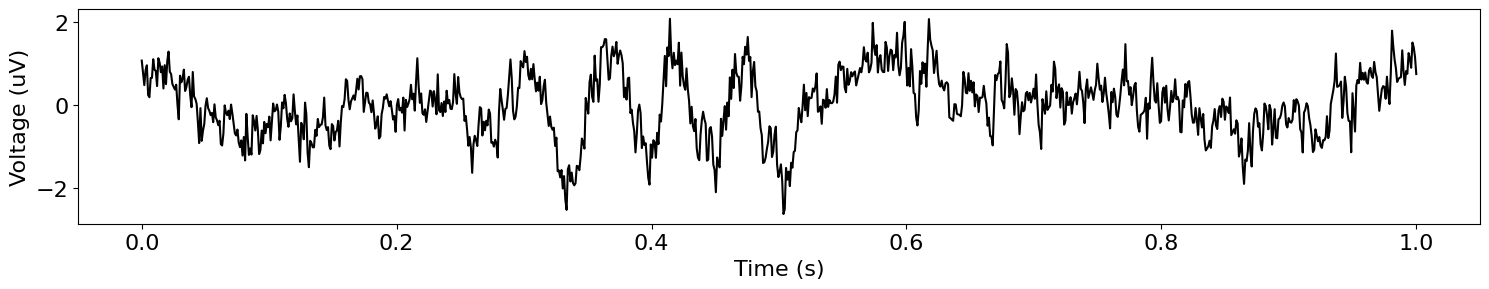

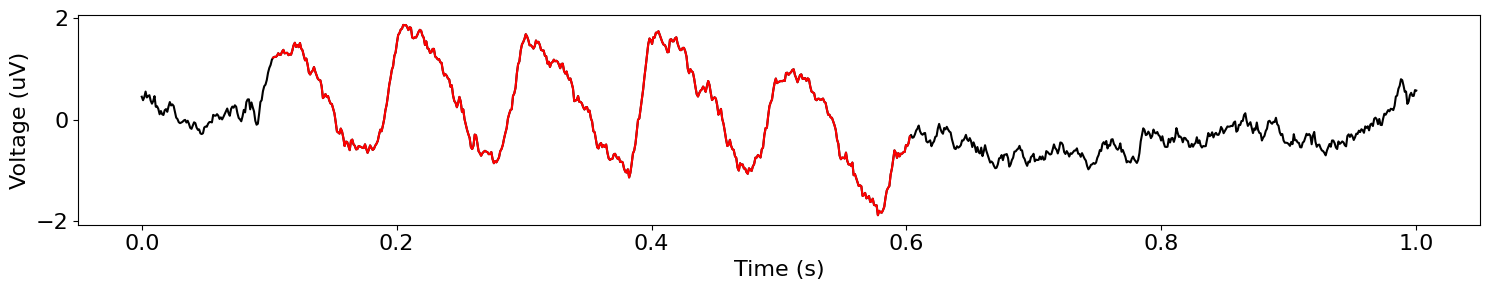

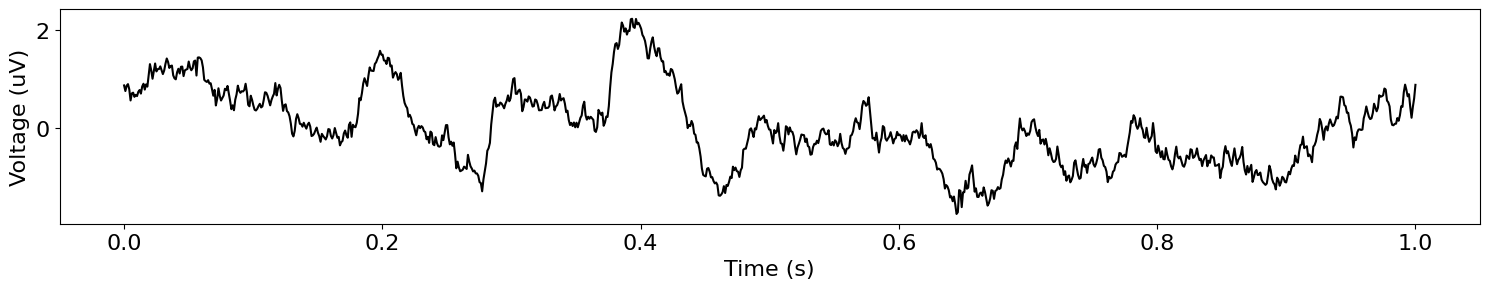

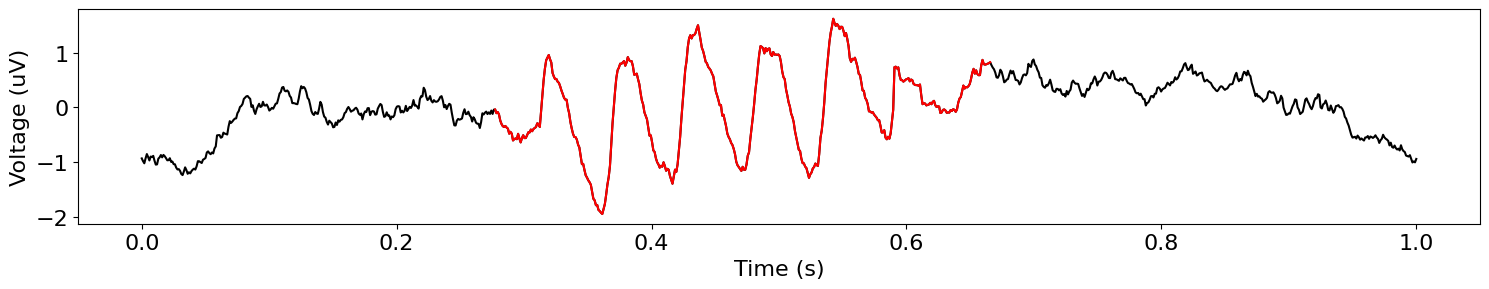

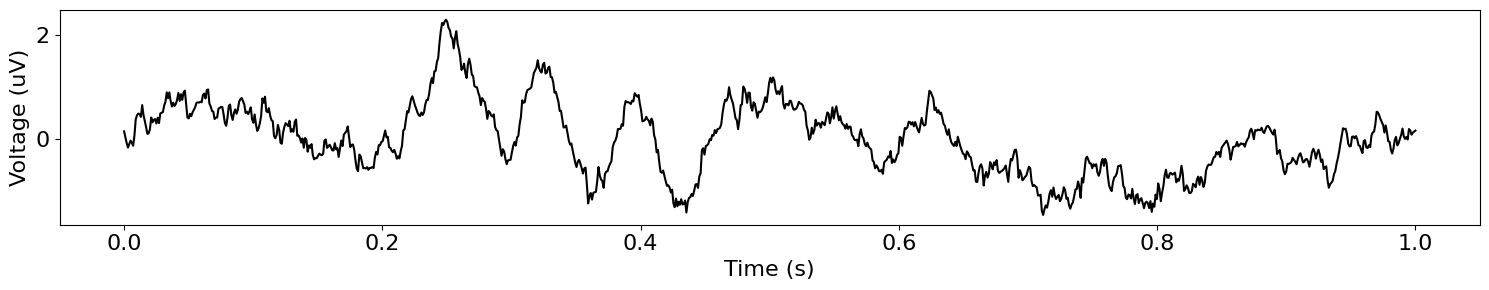

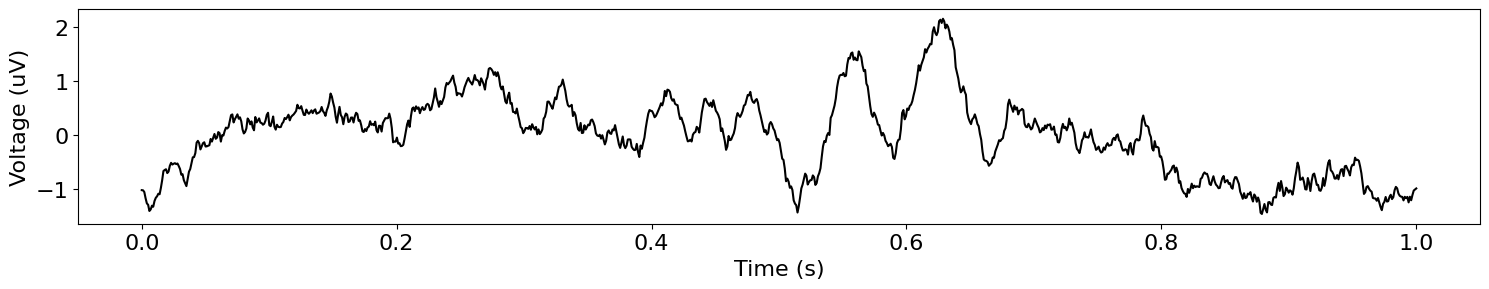

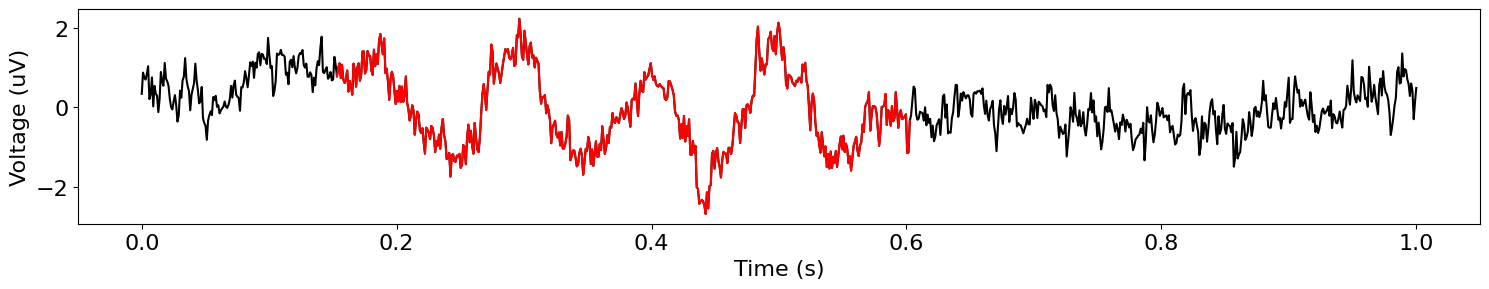

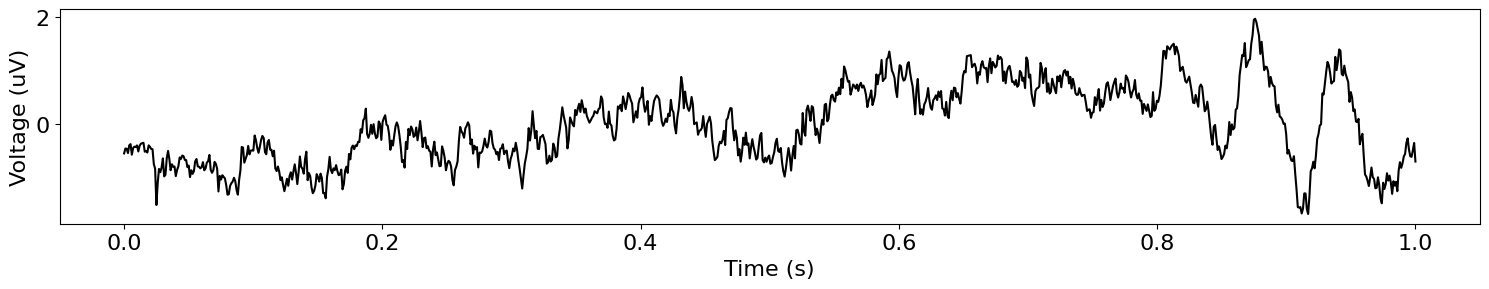

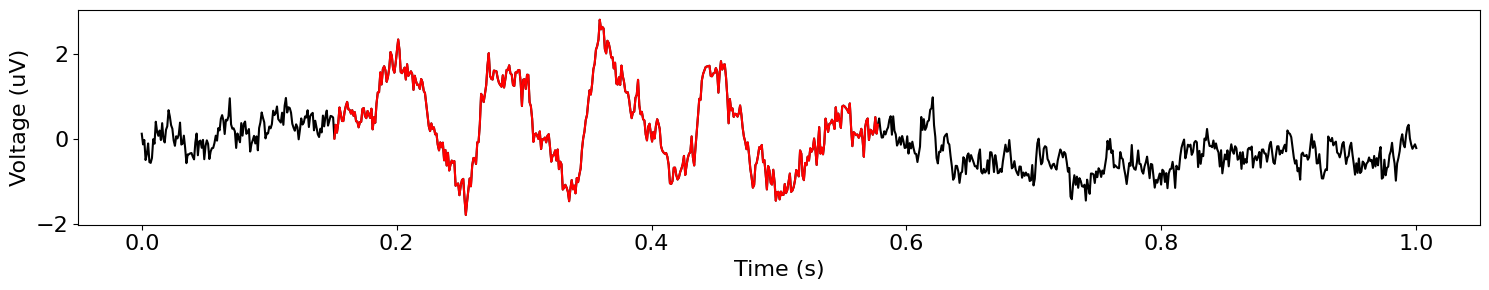

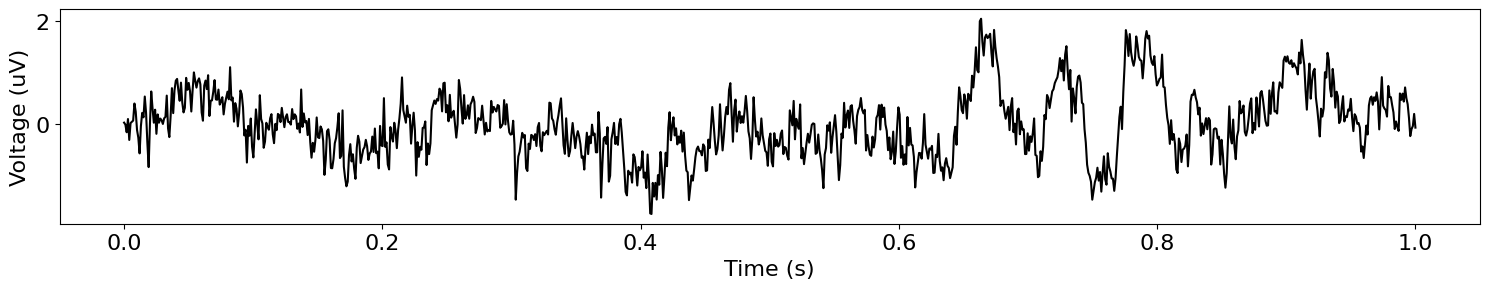

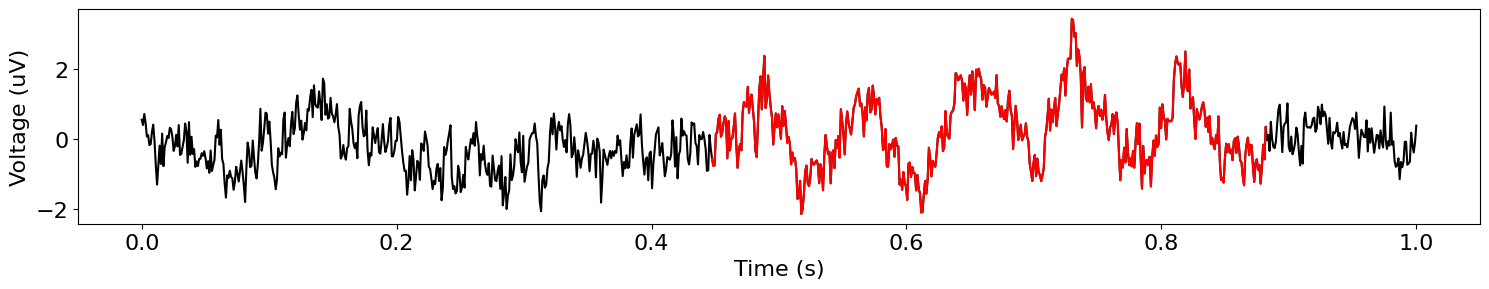

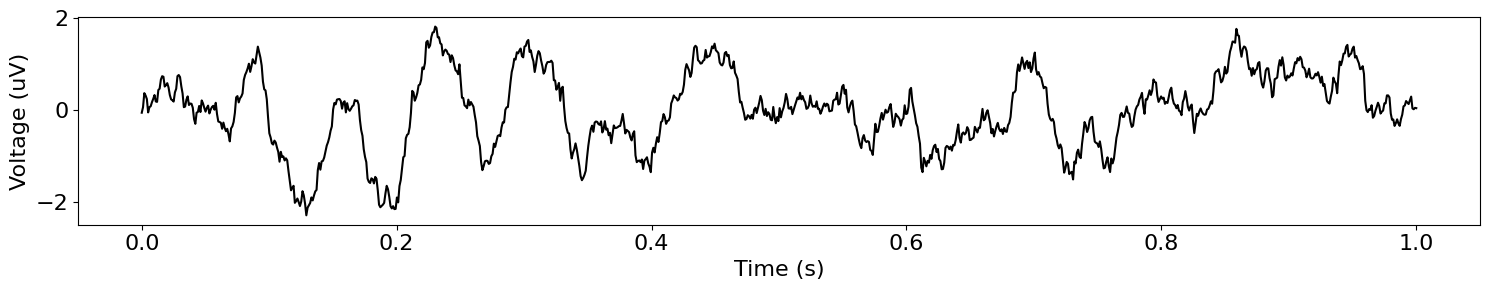

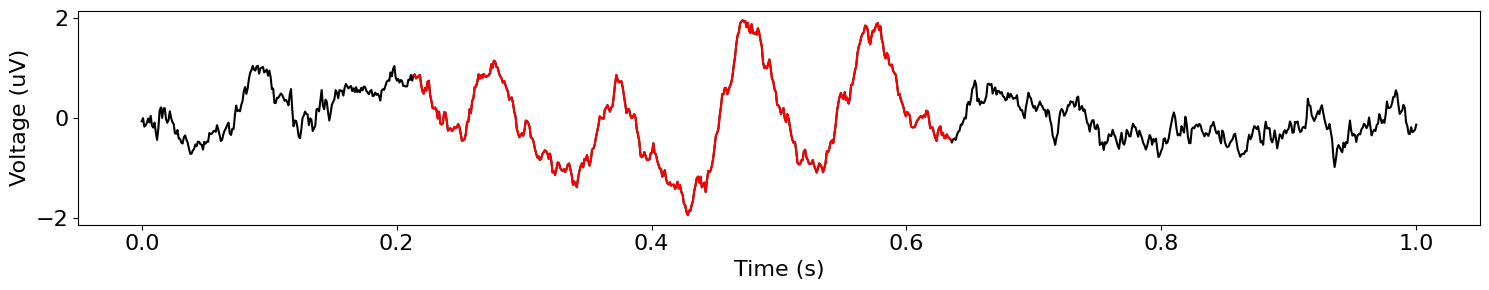

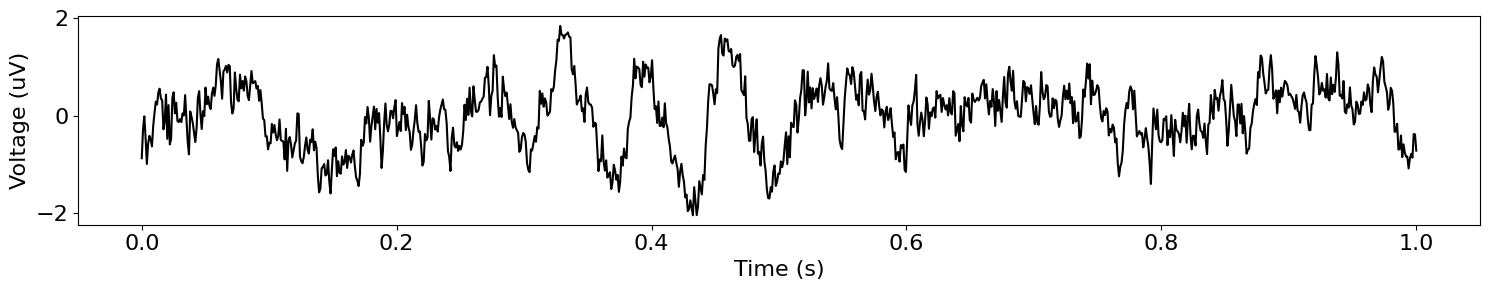

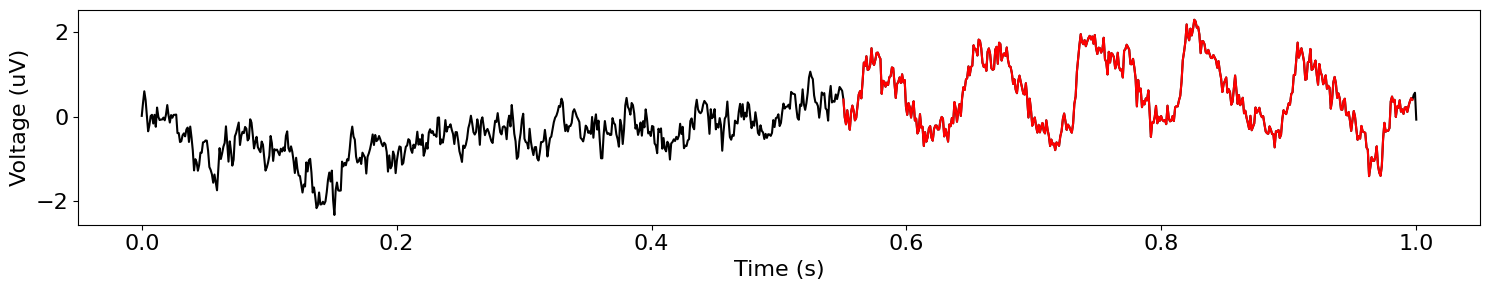

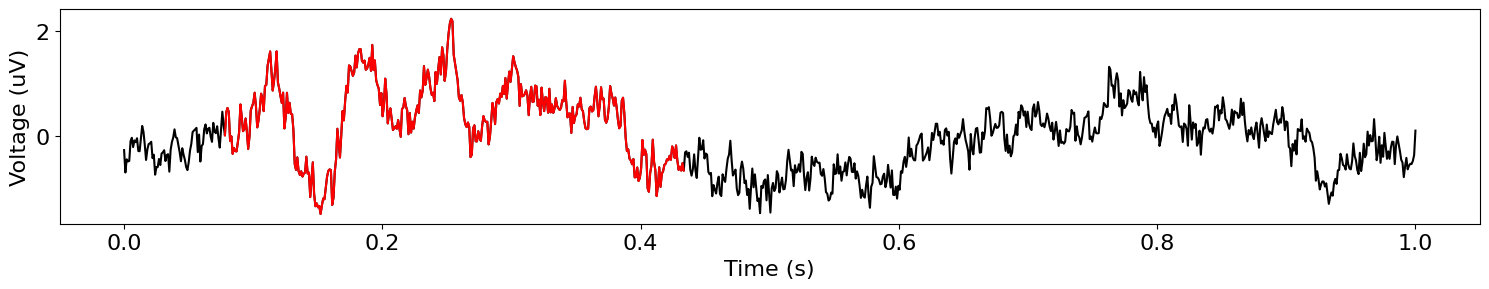

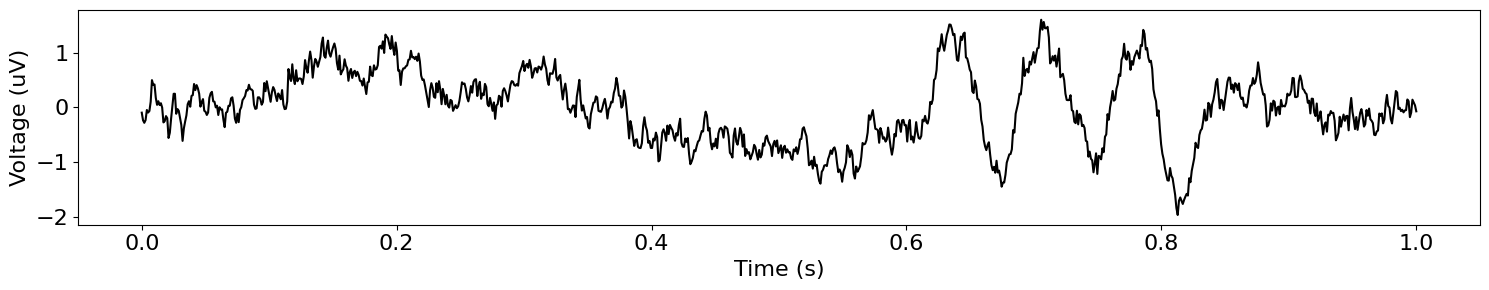

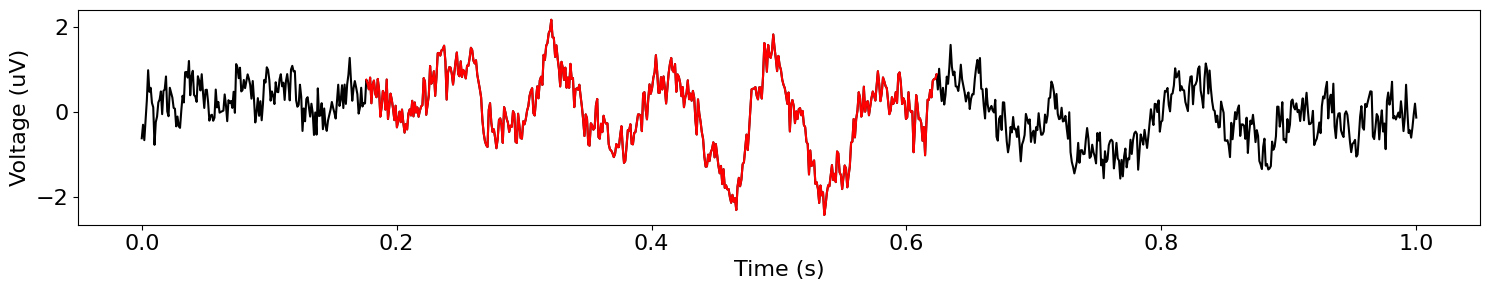

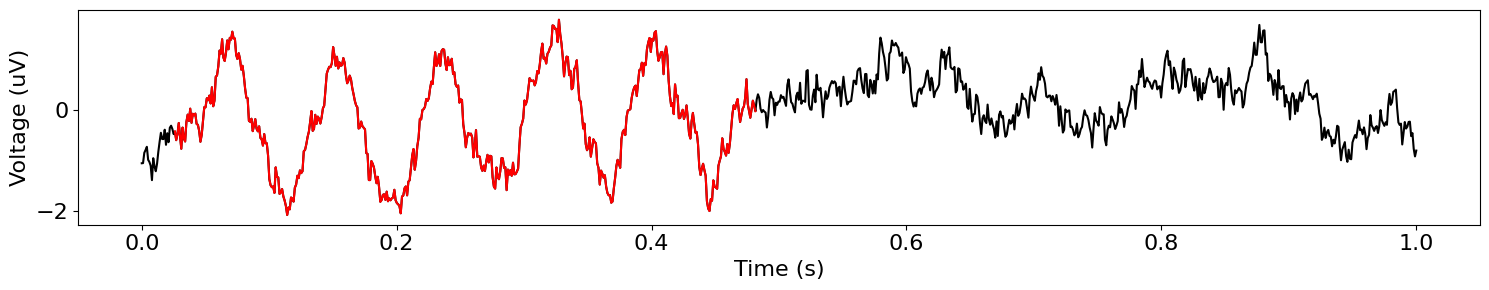

In [10]:
'''
y_pred and y_true are variables for auc_roc
  we want to analyze humans as a whole.
  so y_pred is the interval the humans select (on average?)
  let's start with just one lab person.

'''

# initial values to allow for averaging or single perrson burst selections
from sklearn.isotonic import spearmanr


y_pred: list[tuple[int,int]] = [None]*len(ground_truth)
num_pred = 0
for i in range(len(ground_truth)):
    # Here we have code to execute the burst labeling.
    test_signal = results['sigs']['sig_'+str(i + num_real_sigs)]
    test_signal = np.array(test_signal)

    freqs, power_spectral_density = compute_spectrum(fs=fs, sig=test_signal)
    sm = specparam.SpectralModel(peak_width_limits=[1.0, 8.0], max_n_peaks=8)
    sm.fit(freqs, power_spectrum=power_spectral_density)
    [center_frequency, log_power, bandwidth] = specparam.analysis.get_band_peak(
        sm, [10, 20], select_highest=True)
    print(center_frequency)

    is_burst = detect_bursts_dual_threshold(sig=np.array(
        test_signal), fs=fs, f_range=(9, 21), dual_thresh=(1, 2))
    plot_bursts(np.linspace(0, 1, 1000), test_signal, is_burst)

    num_bursts = num_bursting_intervals(is_burst)
    if (num_bursts > 1):
        print(3/0)
    intervals: list[list[int]] = get_bursting_intervals(num_intervals=num_bursts, is_burst=is_burst)
    # should only be one interval:
    if len(intervals)==0:
        y_pred[i]=(0,0)
    else:
        y_pred[i]=(intervals[0][0], intervals[0][1])
    print(y_pred[i])

# sm.fit(freqs = freqs, power_spectrum = power_spectral_density, freq_range=[1.4,15.0])
# sm.report(freqs, power_spectrum=power_spectral_density, freq_range=[1.4,15.0])

In [5]:

import sklearn.metrics


for i in range(len(ground_truth)):
    plt.figure("figure "+str(i))

    selections_indexed_by_labeler = y_pred[i]
    is_burst = detect_bursts_dual_threshold(sig=np.array(
        eeg_signal_profiled_in_this_loop), fs=fs, f_range=(9, 21), dual_thresh=(1, 2))
    curr_sig_idx = i+num_real_sigs
    eeg_signal_profiled_in_this_loop = results['sigs']['sig_'+str(
        i+num_real_sigs)]
    len_curr_sig = len(eeg_signal_profiled_in_this_loop)

    
    plot_bursts(np.linspace(0, 1, 1000), eeg_signal_profiled_in_this_loop, is_burst)
    
    print(str(selections_indexed_by_labeler[0]) + " vs " + str(ground_truth[i][0]))
    plt.axvspan(ground_truth[i][0]/1000,
                ground_truth[i][1]/1000, color='blue', alpha=0.5)

    overlap = 0
    start_overlap = max(
        selections_indexed_by_labeler[0], ground_truth[i][0])
    end_overlap = min(selections_indexed_by_labeler[1], ground_truth[i][1])
    if start_overlap < end_overlap:
        overlap = end_overlap-start_overlap

    y_pred[i] = (selections_indexed_by_labeler[0],selections_indexed_by_labeler[1])


NameError: name 'eeg_signal_profiled_in_this_loop' is not defined

<Figure size 640x480 with 0 Axes>

In [ ]:
ffff

NameError: name 'ffff' is not defined